# Desertification Index from MODIS Satellite Data

In [29]:
#Carrega informações de senha e login
%run "earthdata_login.ipynb"

import pandas as pd
import matplotlib.pyplot as plt
import climateservaccess as ca
import json
import ipywidgets as widgets
import pyperclip
import geopandas as gpd
from shapely.geometry import Polygon
import folium
import datetime
import numpy as np
import os
import requests
import time
import rasterio
import rasterio.plot

## Variables

In [30]:
# Variables for APPEEARS API
api = 'https://appeears.earthdatacloud.nasa.gov/api/'  
_res = 2 # size of analyzed region (units?)
user = _usuario # APPEARS username 
password = _senha # APPEEARS password
_posMaps = [-8.338618191802494, -36.422912179524886] # latitude and longitude 
_ano_inicial = 2001  # start year
_ano_final = 2023  # end year
_NomeLocal = "Tancredo Neves, Belo Jardim - PE"  # location name
inDir = 'cache_data'  # cache directory name

if not os.path.exists(inDir):
    os.makedirs(inDir)
_localdataName = f"{inDir}/{_posMaps[0]} {_posMaps[1]} {_res}"
if not os.path.exists(_localdataName):
    os.makedirs(_localdataName)

## Geographical Window for Analysis

We use the site [Geojson.io](https://geojson.io/) to mark the geographical area to be analyzed.

In [31]:
link = "https://geojson.io/#map=8/"+str(round(_posMaps[0],3))+"/"+str(round(_posMaps[1],3)) # Generate geojson link
print(link)

https://geojson.io/#map=8/-8.339/-36.423


In [32]:
# Creates GEOJson with input geographical coordinates
_quadrado = ca.getBox(_posMaps[0], _posMaps[1], _res) 
data_Json = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            _quadrado[0],
            _quadrado[1],
            _quadrado[2],
            _quadrado[3],
            _quadrado[0]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}
json_string = json.dumps(data_Json, indent=2)
print(json_string)
button = widgets.Button(description="Copiar GeJson")
def on_button_clicked(b):
    pyperclip.copy(json_string)
button.on_click(on_button_clicked)
button

{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -37.422912179524886,
              -7.338618191802494
            ],
            [
              -35.422912179524886,
              -7.338618191802494
            ],
            [
              -35.422912179524886,
              -9.338618191802494
            ],
            [
              -37.422912179524886,
              -9.338618191802494
            ],
            [
              -37.422912179524886,
              -7.338618191802494
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}


Button(description='Copiar GeJson', style=ButtonStyle())

In [33]:
# Show the area of interest in the world map
quadrado = Polygon(_quadrado)
quadrado_gdf = gpd.GeoSeries(quadrado)
geo_json_data = quadrado_gdf.to_json()
mapa = folium.Map(location=[_posMaps[0],_posMaps[1]], zoom_start=9)
#quadrado_gdf.add_to(mapa)
folium.GeoJson(geo_json_data).add_to(mapa)
mapa

## Precipitation Data

Here we gather the monthly precipitation data for all available years in the repository.

In [34]:
def dias_mes(mes, ano):
  data = datetime.date(ano, mes, 1)
  proximo_mes = data.replace(month=data.month % 12 + 1)
  ultimo_dia = proximo_mes - datetime.timedelta(days=1)
  return ultimo_dia.day

def precipitacao_mes(mes, ano):
    ultimodia = dias_mes(mes, ano)
    data_type = 26 #dados de precipitação
    start_date = "{:02d}/01/{}".format(mes, ano) 
    end_date = "{:02d}/{:02d}/{}".format(mes,ultimodia, ano+1)
    operation_type = 'average'
    polygon = _quadrado
    df = ca.getDataFrame(data_type, start_date, end_date, operation_type, polygon)
    data_df = pd.DataFrame(df['data'].to_list())
    valores = data_df["raw_value"].mean()
    return valores

def precipitacao_ano(ano):
    #_localdataName
    arqName = f"{_localdataName}/{ano} precipit data.csv"
    data_type = 26 #dados de precipitação
    start_date = "01/01/{}".format(ano) 
    end_date = "12/31/{}".format(ano)
    operation_type = 'average'
    polygon = _quadrado
    if os.path.exists(arqName):
        print(f"Arquivo do ano de {ano} já baixado, carregando arquivos locais ...")
        df = pd.read_csv(arqName+".raw")
        return df['raw_value']
    else:
        df = ca.getDataFrame(data_type, start_date, end_date, operation_type, polygon)
        df.to_csv(arqName)
        data_df = pd.DataFrame(df['data'].to_list())
        data_df['raw_value'].to_csv(arqName+".raw")
        return data_df['raw_value']
def downloadinfo(file_url, name):
    response = requests.get(file_url, stream=True)
    file_size = int(response.headers.get("content-length", 0))
    progress = tqdm.tqdm(total=file_size, unit="B", unit_scale=True)
    with open(name, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            f.write(chunk)
            progress.update(len(chunk))
    progress.close()
_precipitacao = {}
for i in range(_ano_inicial,_ano_final+1):
    _precipitacao[i] = precipitacao_ano(i)

Arquivo do ano de 2001 já baixado, carregando arquivos locais ...
Arquivo do ano de 2002 já baixado, carregando arquivos locais ...
Arquivo do ano de 2003 já baixado, carregando arquivos locais ...
Arquivo do ano de 2004 já baixado, carregando arquivos locais ...
Arquivo do ano de 2005 já baixado, carregando arquivos locais ...
Arquivo do ano de 2006 já baixado, carregando arquivos locais ...
Arquivo do ano de 2007 já baixado, carregando arquivos locais ...
Arquivo do ano de 2008 já baixado, carregando arquivos locais ...
Arquivo do ano de 2009 já baixado, carregando arquivos locais ...
Arquivo do ano de 2010 já baixado, carregando arquivos locais ...
Arquivo do ano de 2011 já baixado, carregando arquivos locais ...
Arquivo do ano de 2012 já baixado, carregando arquivos locais ...
Arquivo do ano de 2013 já baixado, carregando arquivos locais ...
Arquivo do ano de 2014 já baixado, carregando arquivos locais ...
Arquivo do ano de 2015 já baixado, carregando arquivos locais ...
Arquivo do

In [35]:
_dados = pd.DataFrame()
_dados["Ano"] = []
_dados["Precipitacao"] = []
for i in range(_ano_inicial,_ano_final+1):
    total = _precipitacao[i].sum()
    _dados.loc[len(_dados.index)] = [i, total]
_dados["Ano"] = _dados["Ano"].astype(int)
_dados

,Ano,Precipitacao
0,2001,427.785007
1,2002,572.865263
2,2003,361.102005
3,2004,682.899511
4,2005,502.663500
5,2006,393.385254
6,2007,448.735259
7,2008,520.711752
8,2009,661.577256
9,2010,741.753752


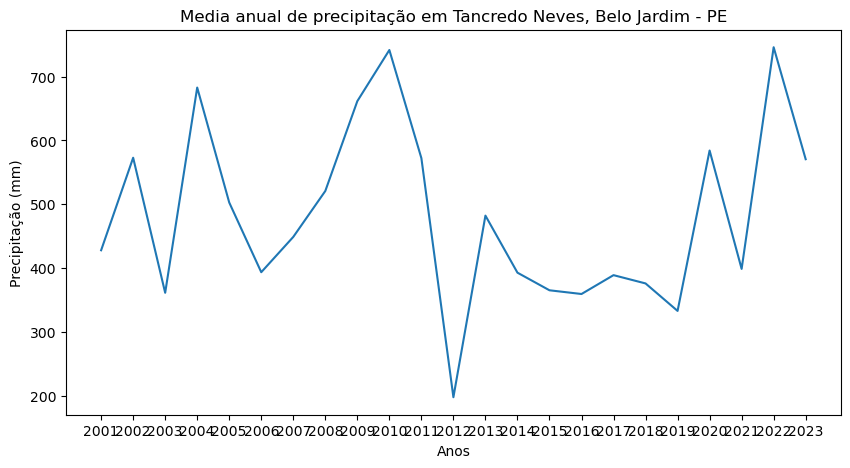

In [36]:
plt.figure(figsize=(10,5))
plt.plot(_dados["Ano"], _dados["Precipitacao"])
plt.xticks(np.arange(_ano_inicial, _ano_final+1, 1), [str(i) for i in range(_ano_inicial, _ano_final+1)])
plt.xlabel('Anos')
plt.ylabel('Precipitação (mm)')
plt.title(f'Media anual de precipitação em {_NomeLocal}')
plt.show()

## Evapotranspiration Data

In [37]:
token_response = requests.post('{}login'.format(api), auth=(user, password)).json()
token = token_response['token']                 
head = {'Authorization': 'Bearer {}'.format(token)}
print(token_response, token)

{'token_type': 'Bearer', 'token': 'cM7nL0lna2TdCunTavZ7ZoWmL1aGEKT2NPBlotnvLDd0gZo1CfMBZzb_yzjiHtTkFuV6A5wDaPls-zGepOHctQ', 'expiration': '2024-01-26T20:36:12Z'} cM7nL0lna2TdCunTavZ7ZoWmL1aGEKT2NPBlotnvLDd0gZo1CfMBZzb_yzjiHtTkFuV6A5wDaPls-zGepOHctQ


In [38]:
produto_usado = "MOD16A3GF.061"
lst_response = requests.get('{}product/{}'.format(api, produto_usado)).json()
list(lst_response.keys())

['ET_500m', 'ET_QC_500m', 'LE_500m', 'PET_500m', 'PLE_500m']

In [39]:
projections = requests.get('{}spatial/proj'.format(api)).json() 
projs = {}                                  # Create an empty dictionary
for p in projections: projs[p['Name']] = p
projs.keys() 

dict_keys(['native', 'geographic', 'sinu_modis', 'albers_weld_alaska', 'albers_weld_conus', 'albers_ard_alaska', 'albers_ard_conus', 'albers_ard_hawaii', 'easegrid_2_global', 'easegrid_2_north'])

In [40]:
prodLayer = []
bandas_usadas = ['ET_500m',  'PET_500m']
for l in lst_response.keys():
    if l in bandas_usadas:
        prodLayer.append({
                "layer": l,
                "product": produto_usado
              })
prodLayer

[{'layer': 'ET_500m', 'product': 'MOD16A3GF.061'},
 {'layer': 'PET_500m', 'product': 'MOD16A3GF.061'}]

In [41]:
#Configuraçoes de tarefa
task_type = ['point','area']        # Type of task, area or point
proj = projs['native']['Name']  # Set output projection 
outFormat = ['geotiff', 'netcdf4']  # Set output file format type
recurring = True                   # Specify True for a recurring date range
yearRange = [_ano_inicial, _ano_final]
task_name = _NomeLocal+" "+str(_ano_inicial)
task = {
        'task_type': task_type[1],
        'task_name': task_name,
        'params': {
             'dates': [
             {
                 'startDate': '01-01',
                 'endDate': '12-31',
                 'yearRange': yearRange,
                 'recurring': recurring
             }],
             'layers': prodLayer,
             'output': {
                     'format': {
                             'type': outFormat[0]}, 
                             'projection': proj},
             'geo': data_Json,
        }
    }
task

{'task_type': 'area',
 'task_name': 'Tancredo Neves, Belo Jardim - PE 2001',
 'params': {'dates': [{'startDate': '01-01',
    'endDate': '12-31',
    'yearRange': [2001, 2023],
    'recurring': True}],
  'layers': [{'layer': 'ET_500m', 'product': 'MOD16A3GF.061'},
   {'layer': 'PET_500m', 'product': 'MOD16A3GF.061'}],
  'output': {'format': {'type': 'geotiff'}, 'projection': 'native'},
  'geo': {'type': 'FeatureCollection',
   'features': [{'type': 'Feature',
     'properties': {},
     'geometry': {'coordinates': [[[-37.422912179524886, -7.338618191802494],
        [-35.422912179524886, -7.338618191802494],
        [-35.422912179524886, -9.338618191802494],
        [-37.422912179524886, -9.338618191802494],
        [-37.422912179524886, -7.338618191802494]]],
      'type': 'Polygon'}}]}}}

In [42]:
task_response = ""
_appEEARsDir = _localdataName+"/"+task_name
if not os.path.exists(_appEEARsDir):
    os.makedirs(_appEEARsDir)
    task_response = requests.post('{}task'.format(api), json=task, headers=head).json()
print(task_response)

In [43]:
def status(id_tarefa):
    return requests.get('{}task/{}'.format(api, id_tarefa), headers=head).json()['status']
if task_response != "":
    task_id = task_response['task_id']                                               
    status_response = requests.get('{}status/{}'.format(api, task_id), headers=head).json() 
    print(status_response)
    starttime = time.time()
    intervalo = 20.0
    _status = status(task_id)
    while _status != 'done':
        _status = status(task_id)
        time.sleep(intervalo - ((time.time() - starttime) % intervalo))
        print(_status)
    print(_status)
else:
    print("Os dados já haviam sido baixados")

Os dados já haviam sido baixados


In [44]:
if task_response != "":
    bundle = requests.get('{}bundle/{}'.format(api,task_id), headers=head).json()  # Call API and return bundle contents for the task_id as json
    files = {}                                                       # Create empty dictionary
    for f in bundle['files']: files[f['file_id']] = f['file_name']
    cont = 0
    numero = len(files)
    for f in files:
        if files[f].endswith('.tif'):
            filename = files[f].split('/')[1]
        else:
            filename = files[f] 
        if os.path.exists(_appEEARsDir +"/"+filename):
            cont += 1
        else:
            dl = requests.get('{}bundle/{}/{}'.format(api, task_id, f), headers=head, stream=True, allow_redirects = 'True')
            filepath = os.path.join(_appEEARsDir, filename)                                                      
            with open(filepath, 'wb') as f:                                                                
                for data in dl.iter_content(chunk_size=8192): f.write(data)
            cont += 1
        print(f"Baixando arquivos {cont} / {numero}")
    print('Todos os arquivos da tarefa salvos em: {}'.format(_appEEARsDir))

In [45]:
if os.path.exists(_appEEARsDir +"/MOD16A3GF-061-Statistics.csv"):
    _dataEvapo = pd.read_csv(_appEEARsDir +"/MOD16A3GF-061-Statistics.csv")
_dataEvapo.head()

,File Name,Dataset,aid,Date,Count,Minimum,Maximum,Range,Mean,Standard Deviation,Variance,Upper Quartile,Upper 1.5 IQR,Median,Lower 1.5 IQR,Lower Quartile
0,MOD16A3GF_061_ET_500m_doy2001001_aid0001,ET_500m,aid0001,2001-01-01,227647,182.5,2274.1,"(182.5,2274.1)",710.232274,233.017757,54297.275202,861.4,1350.4,673.1,182.5,535.4
1,MOD16A3GF_061_ET_500m_doy2002001_aid0001,ET_500m,aid0001,2002-01-01,227647,182.5,2237.0,"(182.5,2237.0)",817.202229,245.000416,60025.203780,999.1,1560.9,784.3,182.5,624.3
2,MOD16A3GF_061_ET_500m_doy2003001_aid0001,ET_500m,aid0001,2003-01-01,227647,182.5,2308.7,"(182.5,2308.7)",635.216301,256.254016,65666.120791,784.0,1294.9,571.2,182.5,443.4
3,MOD16A3GF_061_ET_500m_doy2004001_aid0001,ET_500m,aid0001,2004-01-01,227647,183.0,2270.5,"(183.0,2270.5)",916.431290,211.453269,44712.485139,1071.1,1547.2,902.6,380.1,753.7
4,MOD16A3GF_061_ET_500m_doy2005001_aid0001,ET_500m,aid0001,2005-01-01,227647,182.5,2326.8,"(182.5,2326.8)",810.808490,186.554159,34802.454440,930.5,1315.2,796.7,354.6,674.0


In [46]:
mean_1, mean_2 = np.array_split(_dataEvapo["Mean"], 2)
nova_tabela1 = pd.DataFrame({"ET": mean_1})
nova_tabela2 = pd.DataFrame( {"PET": mean_2.to_list()})
_dados["ET"] = nova_tabela1["ET"]
_dados["PET"] = nova_tabela2["PET"]
_dados

,Ano,Precipitacao,ET,PET
0,2001,427.785007,710.232274,2275.961984
1,2002,572.865263,817.202229,2267.760672
2,2003,361.102005,635.216301,2257.887618
3,2004,682.899511,916.431290,2257.923297
4,2005,502.663500,810.808490,2296.819270
5,2006,393.385254,774.562784,2322.496370
6,2007,448.735259,791.207974,2278.583871
7,2008,520.711752,860.817590,2284.985973
8,2009,661.577256,918.823369,2268.901603
9,2010,741.753752,852.605698,2286.930301


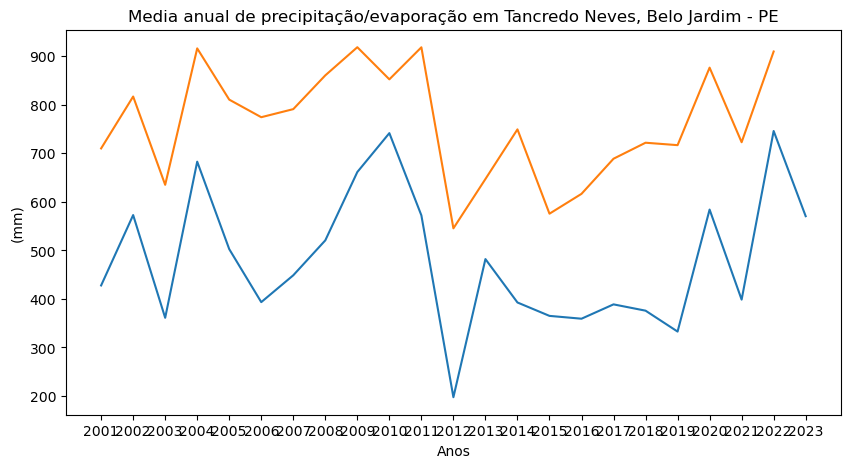

In [47]:
plt.figure(figsize=(10,5))
plt.plot(_dados["Ano"], _dados["Precipitacao"])
plt.plot(_dados["Ano"], _dados["ET"])
plt.xticks(np.arange(_ano_inicial, _ano_final+1, 1), [str(i) for i in range(_ano_inicial, _ano_final+1)])
plt.xlabel('Anos')
plt.ylabel('(mm)')
plt.title(f'Media anual de precipitação/evaporação em {_NomeLocal}')
plt.show()

In [48]:
_dados['Indice de Aridez UNEP'] = _dados["Precipitacao"] / _dados["PET"]
_dados['Aridez'] = _dados["Precipitacao"] / _dados["ET"]
_dados

,Ano,Precipitacao,ET,PET,Indice de Aridez UNEP,Aridez
0,2001,427.785007,710.232274,2275.961984,0.187958,0.602317
1,2002,572.865263,817.202229,2267.760672,0.252613,0.701008
2,2003,361.102005,635.216301,2257.887618,0.159929,0.568471
3,2004,682.899511,916.431290,2257.923297,0.302446,0.745173
4,2005,502.663500,810.808490,2296.819270,0.218852,0.619953
5,2006,393.385254,774.562784,2322.496370,0.169380,0.507880
6,2007,448.735259,791.207974,2278.583871,0.196936,0.567152
7,2008,520.711752,860.817590,2284.985973,0.227884,0.604904
8,2009,661.577256,918.823369,2268.901603,0.291585,0.720027
9,2010,741.753752,852.605698,2286.930301,0.324345,0.869985


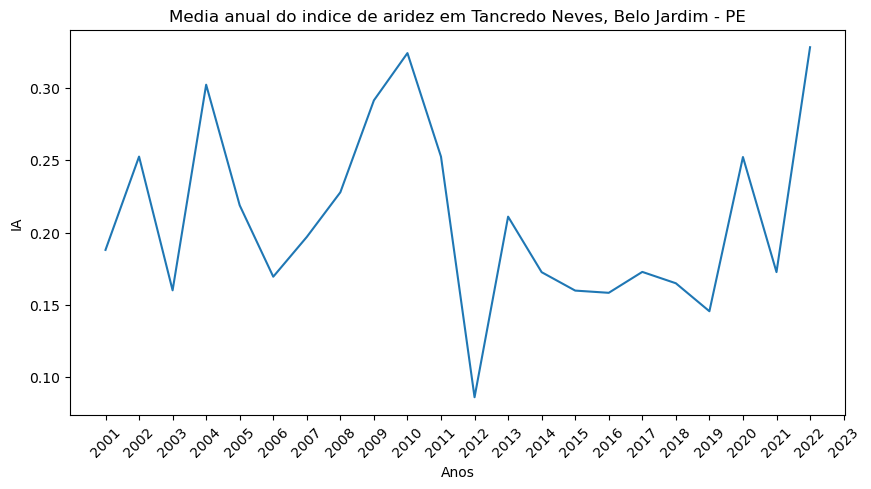

In [49]:
a, b = np.polyfit(_dados["Ano"], _dados["Indice de Aridez UNEP"], 1)
plt.figure(figsize=(10,5))
plt.plot(_dados["Ano"], _dados["Indice de Aridez UNEP"])
plt.plot(_dados["Ano"], a * _dados["Ano"] + b, 'r-')
plt.xticks(np.arange(_ano_inicial, _ano_final+1, 1), [str(i) for i in range(_ano_inicial, _ano_final+1)], rotation=45)
plt.xlabel('Anos')
plt.ylabel('IA')
plt.title(f'Media anual do indice de aridez em {_NomeLocal}')
plt.show()

# calculando resultados

In [50]:
def categoria_climatica(indice):
    if indice >= 0.65:
        return 'Úmida'
    elif indice >= 0.5:
        return 'Subúmida'
    elif indice >= 0.2:
        return 'Semiárida'
    elif indice >= 0.05:
        return 'Árida'
    else:
        return 'Hiperárida'
def risco_desertificacao(ai):
  if ai < 0.05:
    return "Acima de Muito Alto (MMA)"
  elif 0.05 <= ai <= 0.20:
    return "Muito Alto (MA)"
  elif 0.21 <= ai <= 0.50:
    return "Alto (A)"
  elif 0.51 <= ai <= 0.65:
    return "Moderado (M)"
  else:
    return "Baixo (B)"
_IndiceAridez = _dados['Indice de Aridez UNEP'].mean()
_Aridez = _dados['Indice de Aridez UNEP'].mean()
_AriderN = (a * _dados["Ano"] + b).mean()
aridez = _dados.loc[_dados['Ano'] == _ano_final, 'Indice de Aridez UNEP'].values[0]
print(f"Essa região está classificada atualmente como sendo uma região {aridez:.2f}, o que lhe classifica como uma região {categoria_climatica(aridez)}")
print(f"Entre os anos de {_ano_inicial } e {_ano_final}, a região teve um indice medio de {_AriderN:.2f}, o que lhe classifica como uma região {categoria_climatica(_AriderN)}")
print(f"A chance de desertificação da região está classificada como {risco_desertificacao(_AriderN)}")
if a < 0:
    print("Foi observado um processo de diminuição do total de chuva em relação ao total de evaporação")

Essa região está classificada atualmente como sendo uma região nan, o que lhe classifica como uma região Hiperárida
Entre os anos de 2001 e 2023, a região teve um indice medio de nan, o que lhe classifica como uma região Hiperárida
A chance de desertificação da região está classificada como Baixo (B)


In [51]:
_dados["Aridez2"] = _dados["ET"] / _dados["PET"]
_Aridez2 = _dados['Aridez2'].mean()
print(f"Comparando os 2 indices para verificar equivalencia {_Aridez:.2f} ~= {_Aridez2:.2f}")

Comparando os 2 indices para verificar equivalencia 0.21 ~= 0.33


In [52]:
# def mostraGraficoDoAno(ano):
#     for f in files:
#         if files[f].endswith('.tif'):
#             nome = files[f].split('/')[1]
#         else:
#             nome = files[f]
#         if "_ET_5" in nome and f"doy{ano}" in nome:
#             et_tif = nome
#         if "_PET_5" in nome and f"doy{ano}" in nome:
#             pet_tif = nome
#     et_tif = _appEEARsDir+"/"+et_tif
#     pet_tif = _appEEARsDir+"/"+pet_tif
#     with rasterio.open(et_tif) as et:
#       et_data = et.read(1) 
#     with rasterio.open(pet_tif) as pet:
#       pet_data = pet.read(1) 
#     arid_data = et_data / pet_data
#     plt.imshow(arid_data, cmap='gist_yarg', vmin=0, vmax=1)
#     plt.show()
# mostraGraficoDoAno(_ano_final-1)

In [53]:
nomes = os.listdir(_appEEARsDir) 
_arquivos = [nome for nome in nomes if os.path.isfile(os.path.join(_appEEARsDir, nome))] 

In [54]:
_bounds = 0
def mostraGraficoDoAno(ano):
    for f in _arquivos:
        nome = f#_arquivos[f]
        if "_ET_5" in nome and f"doy{ano}" in nome:
            et_tif = nome
        if "_PET_5" in nome and f"doy{ano}" in nome:
            pet_tif = nome
    et_tif = _appEEARsDir+"/"+et_tif
    pet_tif = _appEEARsDir+"/"+pet_tif
    with rasterio.open(et_tif) as et:
      et_data = et.read(1) 
    with rasterio.open(pet_tif) as pet:
      pet_data = pet.read(1) 
    arid_data = et_data / pet_data
    return arid_data
def PlotGrafico(data):
    plt.imshow(data, cmap='jet_r', vmin=0, vmax=1)
    plt.colorbar(label='Valor')
    mascara = np.where(data < 0.2, 0, np.nan)
    plt.imshow(mascara, cmap='gray', vmin=0, vmax=1, alpha=1)
    plt.show()
#PlotGrafico(mostraGraficoDoAno(_ano_final-1))

In [55]:
_dado = []
for i in range(_ano_inicial,_ano_final,2):
    _dado.append(mostraGraficoDoAno(i))
_final = np.mean(_dado, axis=0)

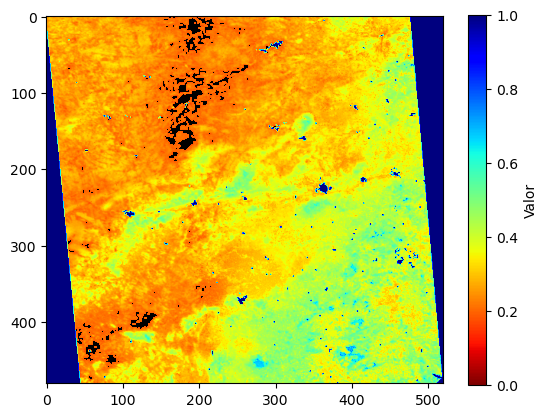

In [56]:
PlotGrafico(_final)